# Jonathan Halverson
# Friday, November 24, 2017
# CNN on MNIST

Here we write our own CNN to predict on MNIST. Note that this is a simple example in comparison to the best performing models of the day which tend to be very deep yet efficient with respect to the number of parameters (e.g., ResNet).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
batch_size = 200
X_batch, y_batch = mnist.train.next_batch(batch_size)
X_batch.shape

(200, 784)

We need to reshape the data for a 2-d convolutional net:

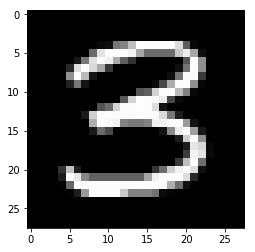

In [4]:
X_batch = X_batch.reshape(batch_size, 28, 28, 1)
single_digit = X_batch[42, :, :, 0]
plt.imshow(single_digit, cmap='gray')

In [24]:
single_digit.max()

1.0

In [5]:
X_valid = mnist.validation.images
y_valid = mnist.validation.labels
X_test = mnist.test.images
y_test = mnist.test.labels

In [6]:
tf.reset_default_graph()

In [7]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, 28 * 28), name="X")
     X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
     y = tf.placeholder(dtype=tf.int64, shape=(None), name="y")

In [8]:
conv_1 = tf.layers.conv2d(X_reshaped, filters=10, kernel_size=7, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
max_pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
conv_2 = tf.layers.conv2d(max_pool_1, filters=5, kernel_size=2, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
max_pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.name_scope("fc1"):
     full_1 = tf.layers.dense(tf.reshape(max_pool_2, shape=[-1, 20]), units=50, activation=tf.nn.relu)

with tf.name_scope("output"):
     logits = tf.layers.dense(full_1, units=10, activation=None, name='outputs')
     Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [9]:
with tf.name_scope('loss'):
     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
     loss = tf.reduce_mean(xentropy, name='loss')

In [10]:
learning_rate = 0.001
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [11]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
cm = tf.confusion_matrix(y, tf.arg_max(logits, dimension=1))

In [12]:
init = tf.global_variables_initializer()

In [13]:
batch_size = 200
n_epochs = 100

In [14]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs):
          for iteration in range(mnist.train.num_examples // batch_size):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if (epoch % 10 == 0):
               print epoch, "train:", accuracy.eval(feed_dict={X:X_batch, y:y_batch}), \
                            "valid:", accuracy.eval(feed_dict={X:X_valid, y:y_valid})
     print "train (entire):", accuracy.eval(feed_dict={X:mnist.train.images, y:mnist.train.labels})
     print "test:", accuracy.eval(feed_dict={X:X_test, y:y_test})
     print "CM:\n", cm.eval(feed_dict={X:X_test, y:y_test})

0 train: 0.3 valid: 0.2948
10 train: 0.9 valid: 0.9036
20 train: 0.95 valid: 0.9424
30 train: 0.965 valid: 0.9496
40 train: 0.93 valid: 0.9558
50 train: 0.945 valid: 0.9598
60 train: 0.93 valid: 0.9612
70 train: 0.97 valid: 0.9644
80 train: 0.95 valid: 0.9664
90 train: 0.96 valid: 0.9684
train (entire): 0.967182
test: 0.9674
CM:
[[ 965    0    1    2    1    5    0    2    4    0]
 [   0 1127    3    3    0    0    0    1    1    0]
 [   6    3  998    8    4    0    1    3    8    1]
 [   4    0    9  969    0   14    0    6    4    4]
 [   1    0    5    0  956    0    1    0    3   16]
 [   3    0    0    7    0  868    4    0    7    3]
 [   6    4    6    0    6    7  924    0    5    0]
 [   2    6   13    1    1    0    0  987    4   14]
 [   3    2    9    9    3    3    3    5  929    8]
 [   6    5    4    5   17    6    0   13    2  951]]


### Next we consider Geron's solution

Geron uses two successive convolutional layers, dropout and early stopping:

In [15]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

In [17]:
tf.reset_default_graph()

In [18]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [19]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [ ]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X:X_batch, y:y_batch})
               
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")